In [1]:
import numpy as np
import pandas as pd
import uuid

from numpy.random import *

In [2]:
def get_sumple_data(target_class, p, Num_purchases):
    SAMPLE_SIZE=1000
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']

    # 平均5, 標準偏差2の正規分布から値を一つ取り出してint型に変換（少数点以下切り捨て）
    visit_num = np.random.normal(5, 2, 1).astype(int)[0]

    lst_df=[]
    for i in range(0,SAMPLE_SIZE):
        # 1ユーザの行動を作成
        ## 来訪ページ数が平均3、標準偏差1の分布から1の値を取得
        _visit_num = np.random.normal(3, 1, 1)[0]
        ## 来訪ページ数が多いと大変そうだったので最大6に設定
        visit_num = np.clip(_visit_num, 1, 6).astype("int")
        # 来訪ページ名を取得
        result_lst=np.random.choice(PRICE_CLASS, visit_num ,p=p)
        result=pd.Series(result_lst, name='来訪ページ')
        ## 1ユーザあたりの行動をデータフレームに入れる
        df_result=result.to_frame()
        ## user_idを付与
        df_result['user_id']=str(uuid.uuid4())
        lst_df.append(df_result)

    df_base=pd.concat(lst_df, axis='index')
    df_drop_dupli=df_base.drop_duplicates()

    df_result=pd.concat([df_drop_dupli[['user_id']]
                        , pd.get_dummies(df_drop_dupli['来訪ページ'])
                        ],
                        axis='columns').groupby('user_id').sum()

    e_z=randn(SAMPLE_SIZE)
    z_mean=(30*df_result[f'{target_class}_1'] + 20*df_result[f'{target_class}_2'] ).mean()

    # シグモイド関数を使ってtarget_class来訪ユーザがより購入しやすいようにする
    z_base=np.array(30*df_result[f'{target_class}_1'] + 20*df_result[f'{target_class}_2']  -z_mean + 5*e_z)
    # シグモイド関数
    from scipy.special import expit
    # シグモイド関数を計算
    z_prob=expit(0.1*z_base)

    # 未購入 or 購入の変数(0は未購入、1は購入)
    Z=np.array([])

    for i in range(SAMPLE_SIZE):
        Z_i=np.random.choice(2 # 0 or 1のどちらかを取得するという意味
                            , size=1 # 1つの値だけ取得する
                            , p=[1-z_prob[i], z_prob[i]] # 購入する確率(1が入る確率)がz_prob[i]
                            )[0]
        Z=np.append(Z, Z_i).astype(int)


    df_result['result']=Z
    df_result['Num_purchases']=Num_purchases

    return df_result

In [3]:
target_class='低価格'
p=[0.4, 0.4, 0.05, 0.05, 0.05, 0.05]
Num_purchases=0

df_first=get_sumple_data(target_class, p, Num_purchases)

In [4]:
target_class='低価格'
p=[0.4, 0.4, 0.05, 0.05, 0.05, 0.05]
Num_purchases=1

df_second=get_sumple_data(target_class, p, Num_purchases)

In [5]:
target_class='中価格'
p=[0.1, 0.1, 0.3, 0.3, 0.1, 0.1]
Num_purchases=2

df_third=get_sumple_data(target_class, p, Num_purchases)

In [6]:
target_class='高価格'
p=[0.1, 0.1, 0.1, 0.1, 0.3, 0.3]
Num_purchases=3

df_4th=get_sumple_data(target_class, p, Num_purchases)

In [7]:
import matplotlib.pyplot as plt # グラフ等の描画用モジュール
from sklearn.model_selection import train_test_split # データを学習用とテスト用に分割する関数
from sklearn.tree import DecisionTreeClassifier # 決定木（分類）

from sklearn.metrics import confusion_matrix, accuracy_score

import sklearn.tree
import japanize_matplotlib

In [8]:
def make_cm(matrix, columns):
    # matrix numpy配列

    # columns 項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

In [11]:
# 学習用とテスト用に分割
def get_DT_result(df):
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']
    x=df[PRICE_CLASS]
    t=df['result']
    x_train, x_test, t_train, t_test = train_test_split(x, t, 
                                                        stratify=t, 
                                                        random_state=0)

    tree_2 = DecisionTreeClassifier(max_depth=2, random_state=0)
    tree_2.fit(x_train, t_train)


    predicted = tree_2.predict(x_test)

    cm = confusion_matrix(t_test, predicted)
    _cm = make_cm(cm, ['未購入', '購入'])

    print('accuracy', accuracy_score(t_test, predicted))
    # 結果の表示
    display(_cm)

    # 決定木を可視化
    plt.figure(figsize=(20, 8))
    sklearn.tree.plot_tree(tree_2, # モデルの名前 
                        class_names=['未購入', '購入'], # クラス名
                        feature_names=PRICE_CLASS,
                        filled=True # 色付きで表示
                        )
    plt.show()

accuracy 0.776


予測結果    
           未購入  購入
正解データ 未購入  107  20
      購入    36  87

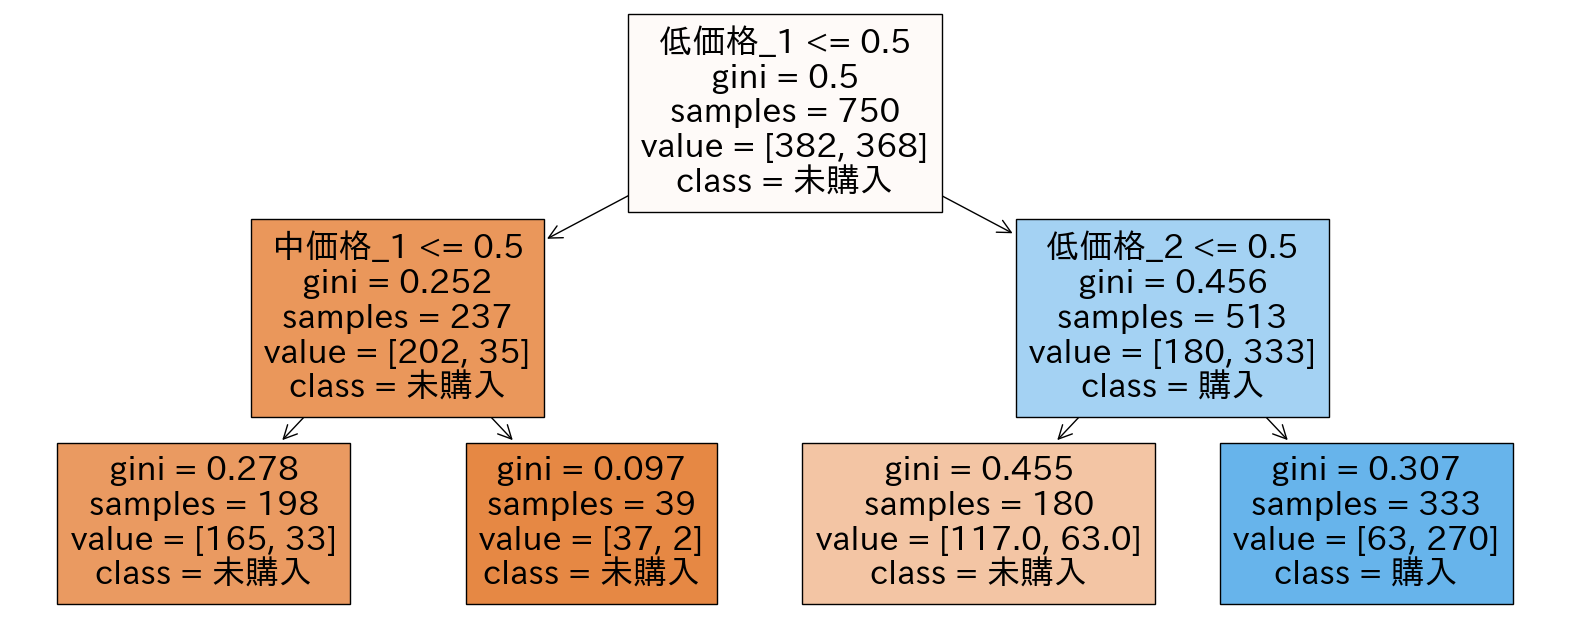

In [12]:
get_DT_result(df_first)

accuracy 0.82


予測結果    
           未購入  購入
正解データ 未購入  110  14
      購入    31  95

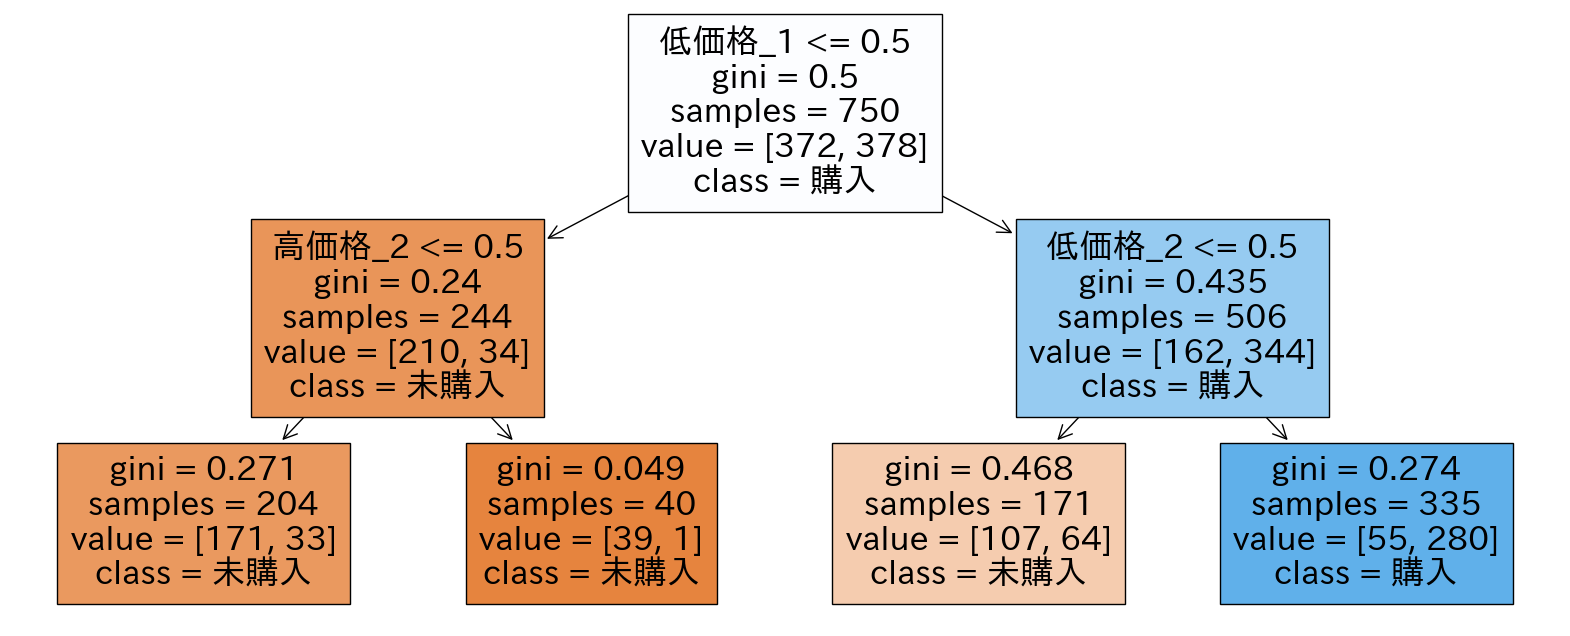

In [13]:
get_DT_result(df_second)


accuracy 0.756


予測結果     
           未購入   購入
正解データ 未購入   85   40
      購入    21  104

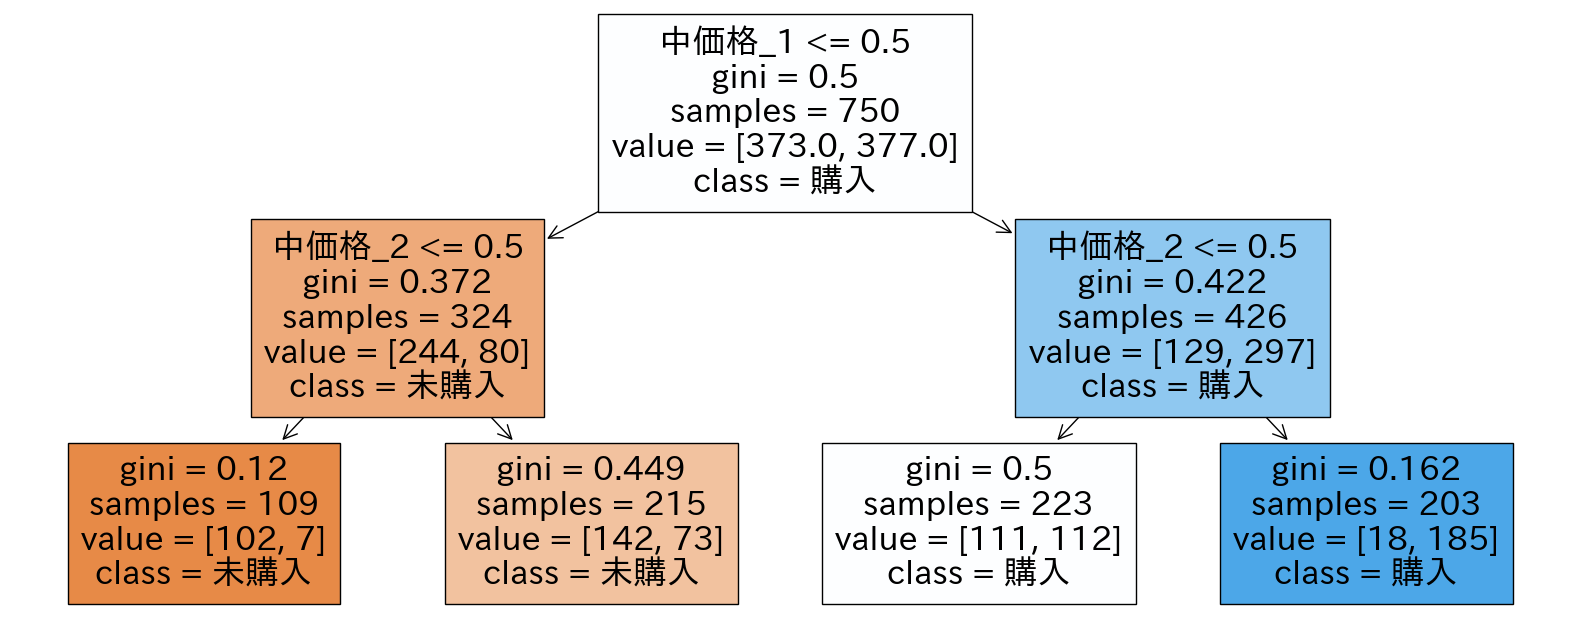

In [14]:
get_DT_result(df_third)

accuracy 0.74


予測結果     
           未購入   購入
正解データ 未購入   80   43
      購入    22  105

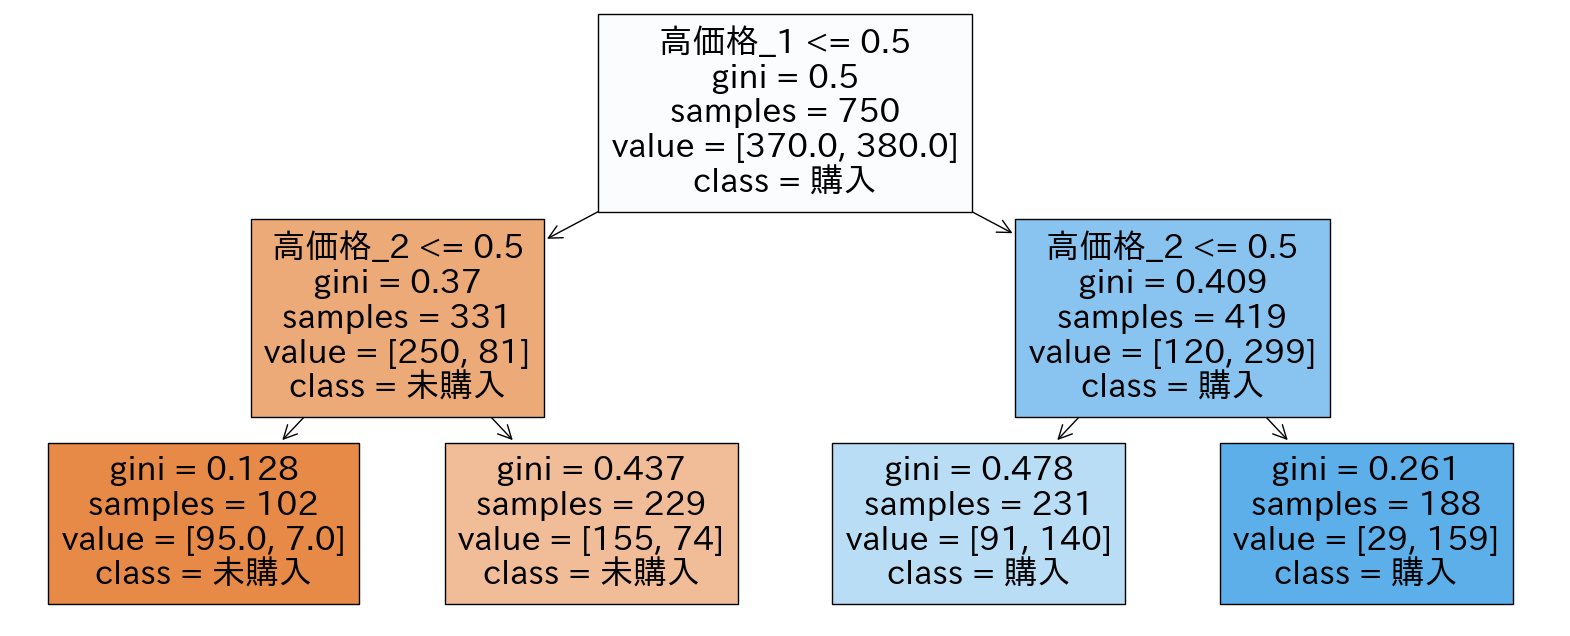

In [15]:
get_DT_result(df_4th)